Name: Yue Gao
Email: yug095@eng.ucsd.edu
PID: A53101273

# Per day counts evaluation

In [203]:
import pickle
data_dir = "./Data/Weather/"
tmax_year_raw=pickle.load(open(data_dir+'tmax_all_years.pickle','r'))
tmax_station_raw=pickle.load(open(data_dir+'tmax_all_stations.pickle','r'))

In [206]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [207]:
station_rdd=sc.parallelize(tmax_station_raw)
year_rdd=sc.parallelize(tmax_year_raw)

In [208]:
tmax_count=station_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)

In [209]:
def YearlyPlots(T,ttl='',yl='',xl='',y=None,x=None,size=(10,7), c=None):
    yearday=[i for i in range(1,366)]
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    if c is not None:
        plot_date(yearday,T, '-',color=c);
    else:
        plot_date(yearday,T, '-', );
    # rotate and align the tick labels so they look better
    #fig.autofmt_xdate()
    ylabel(yl)
    xlabel(xl)
    if y is not None:
        ylim(y)
    if x is not None:
        xlim(x)
    grid()
    title(ttl)

# Assumption

# TMAX

The dip can be explained that at end or begining of the month and Chritmas and National Celebration day, measurements is less because people do not want to work on those days. 

Two facts may influence the dip. One is the stations. A subset of station may have lazy workers or they are located in a special place where people do not want to go to work at the end of the months. Our job is to find these stations and remove the data. Another fact is year, there may be some years when the American economy or environment is not very well that people have less motivation to go to work on some days. 

The algorithm is as below:
First we find the dip point of the figure, (I use slope to represent the dip), then sort the 365 slop and get the first 20 least slope day. Then for every station (year), I calculation the slope of each day and also get the 20 first least slope point. At last I calculate the overlap of the 20 days for each station(year), for those with more overlaps, I define it as bad station (year), then remove the bad stations(years) and compare the good (left) data with the bad data.


### Instructor's feedback
You provide some reasonable explanations: 
* location at a special place where workers are lazy or do no want to go to work at the end of the month.
* Years when the american economy is not well.

However, your analysis is unrelated to these explanations. One thing you could have done regarding explanation one was to find out whether a few stations are responsible for the pattern or whether it is distributed throughout the stations. You could also see if the behaviour is the same for different ranges of years.

No extra credit points.

# SNWD

For snow depth, the dip at the begining or end of the monts is not obvious. It is interesting that in the summer, when it is hot, the counts is high but in the winter, the count is low. I think this is because in the summer, there are even no sown days, so the snow dpth measurements is very easy so people will not find some excuse to be lazy, while in the winter, it snows a lot, so the measurement becomes tougher that people are reluctantly to measure.

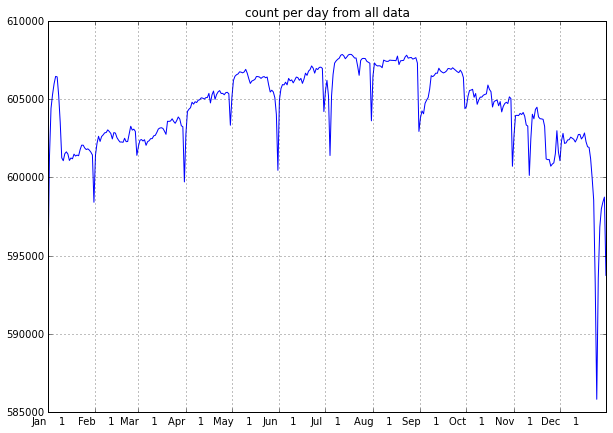

In [210]:
YearlyPlots(tmax_count)
title('count per day from all data');

In [211]:
def get_drop(v):
    res=[]
    for i in range(1,len(v)):
        if(v[i-1]==0):
            res.append((0,i))
        else:
            res.append(((v[i]-v[i-1])*1.0/v[i-1],i))
#             res.append()
    return res

In [212]:
def overlap(v):
    s=0
    for i in v:
        if i in judge:
            s+=1
    return s

In [213]:
sub_rdd=sc.parallelize(get_drop(tmax_count))
judge=np.array(sub_rdd.sortByKey().take(20))[:,1]

In [214]:
judge

array([ 358.,  357.,  364.,  242.,  303.,  184.,  211.,  150.,   89.,
        314.,   30.,  180.,    9.,  325.,  119.,  272.,    8.,   58.,
        356.,  333.])

This is the days that drop fastest

# First we focus on the station effect

In [215]:
test=station_rdd.map(lambda (k,v):(k,get_drop(v)))\
          .map(lambda (k,v):(k,sorted(v,key=lambda x:x[0])))\
          .map(lambda (k,v):(k,np.array(v)[:,1][:20]))

In [216]:
totalnum=station_rdd.count()

In [217]:
overlap_rdd=test.map(lambda (k,v):(overlap(v),k)).sortByKey(False)


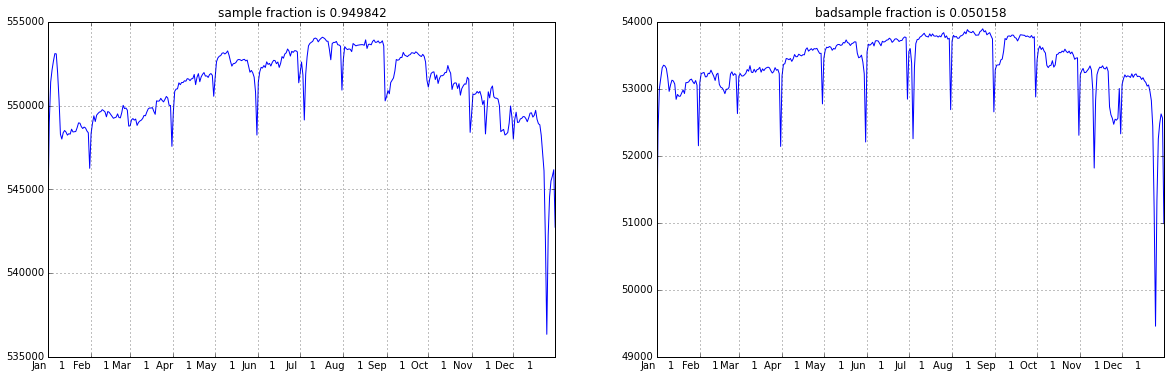

In [218]:
remove_num=1000
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=station_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=station_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/totalnum
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction)
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);

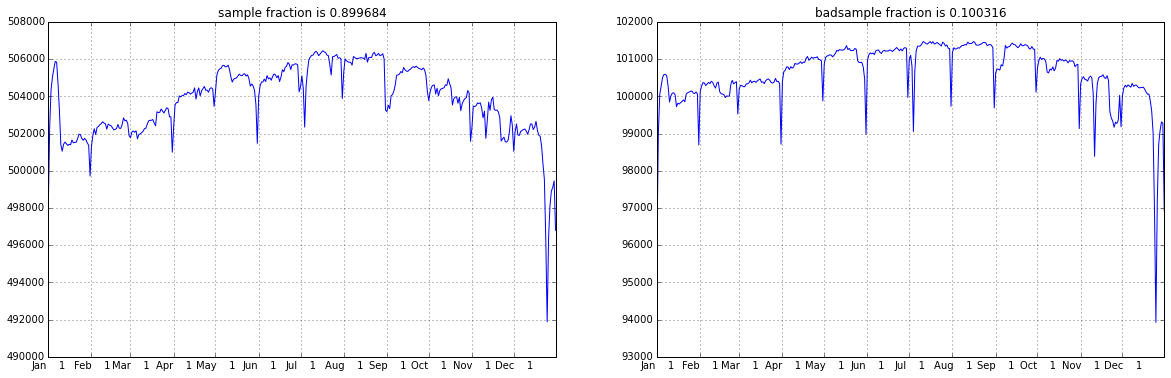

In [219]:
remove_num=2000
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=station_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=station_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/totalnum
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction)
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);

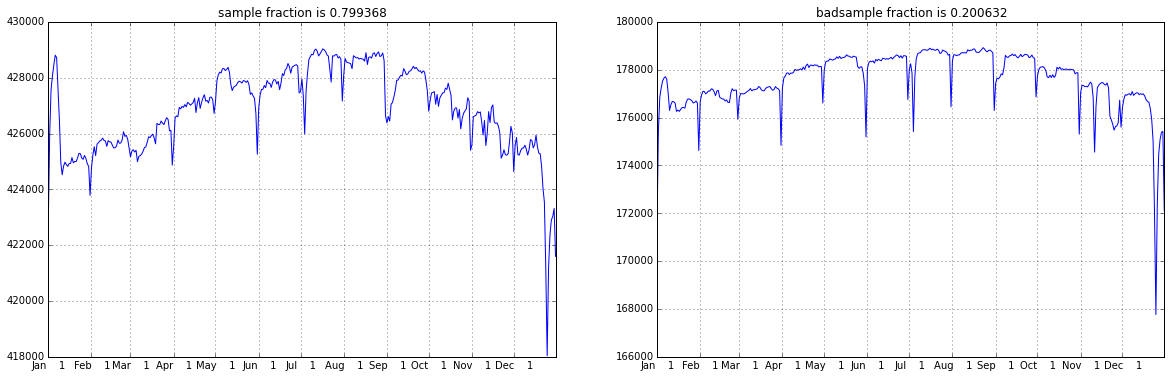

In [220]:
remove_num=4000
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=station_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=station_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/totalnum
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction)
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);



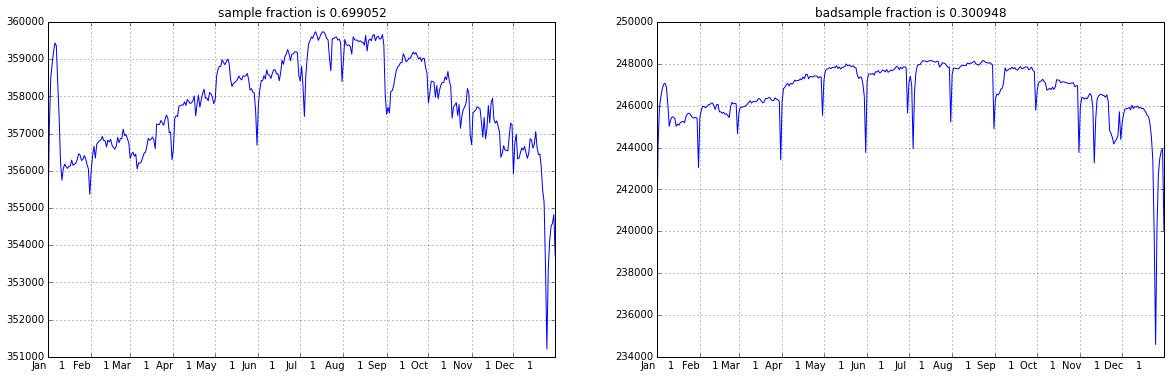

In [221]:
remove_num=6000
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=station_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=station_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/totalnum
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction)
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction)

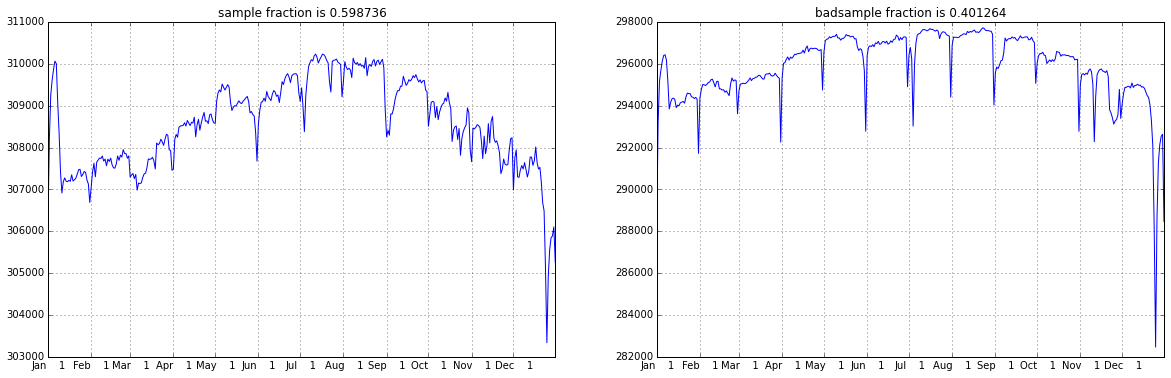

In [222]:
remove_num=8000
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=station_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=station_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/totalnum
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction)
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction)

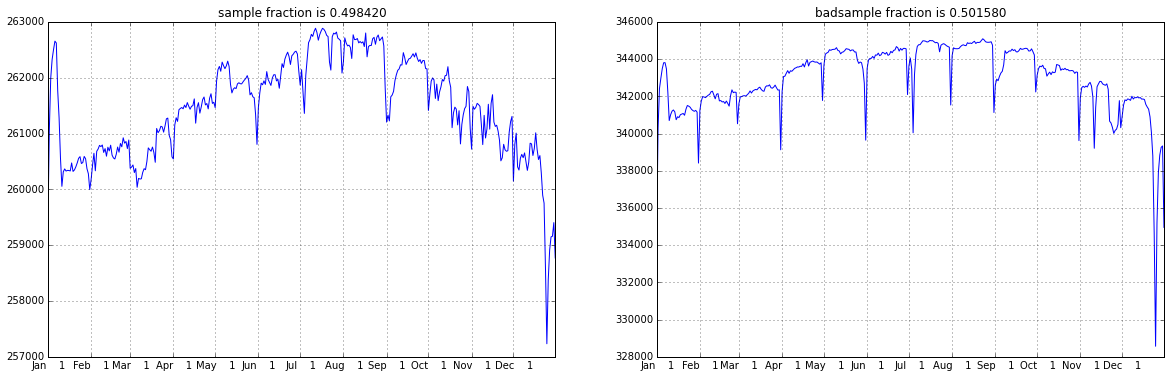

In [223]:
remove_num=10000
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=station_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=station_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/totalnum
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction)
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction)

We can see that with the sample fraction gose down, this means that we remove more and more bad stations which contributes to the dip, the dip can be removed more and more, but we still can not remove the christmas dip and sep 1st (labor day) dip and new year dip. this makes sense. 

# Next we focus on the year fluence 

In [163]:
test_year=year_rdd.map(lambda (k,v):(k,get_drop(v)))\
          .map(lambda (k,v):(k,sorted(v,key=lambda x:x[0])))\
          .map(lambda (k,v):(k,np.array(v)[:,1][:20]))

In [176]:
overlap_rdd=test_year.map(lambda (k,v):(overlap(v),k)).sortByKey(False)
year_num=year_rdd.count()

174

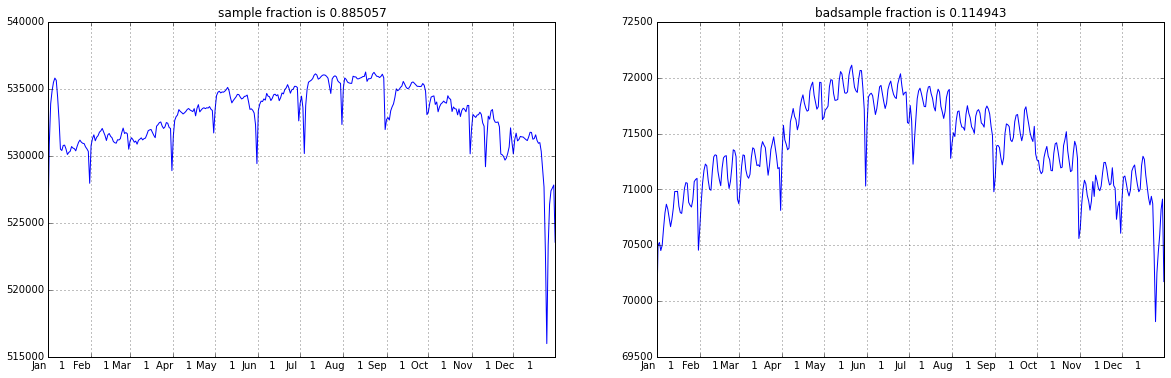

In [188]:
remove_num=20
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=year_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=year_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/year_num
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction);
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);

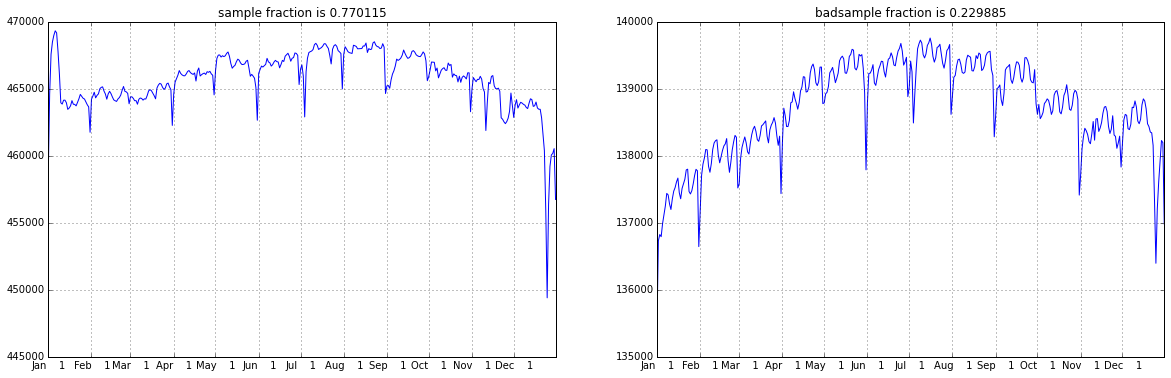

In [190]:
remove_num=40
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=year_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=year_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/year_num
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction);
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);

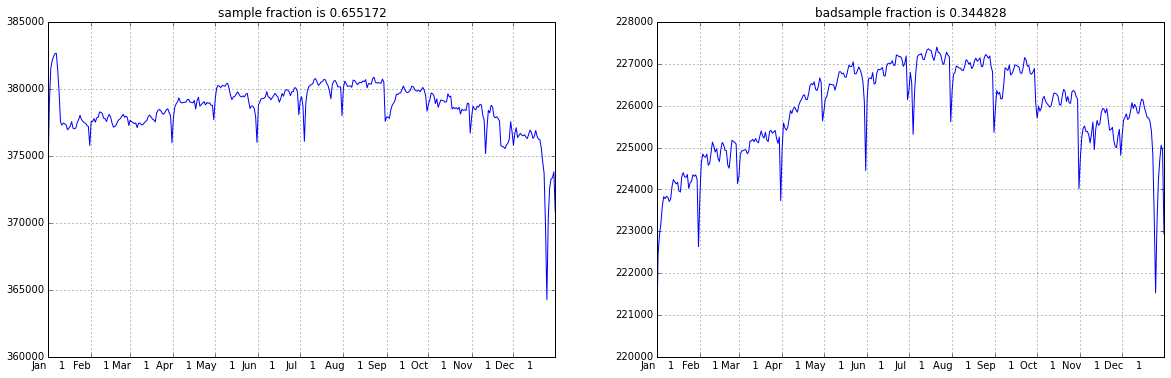

In [191]:
remove_num=60
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=year_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=year_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/year_num
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction);
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);

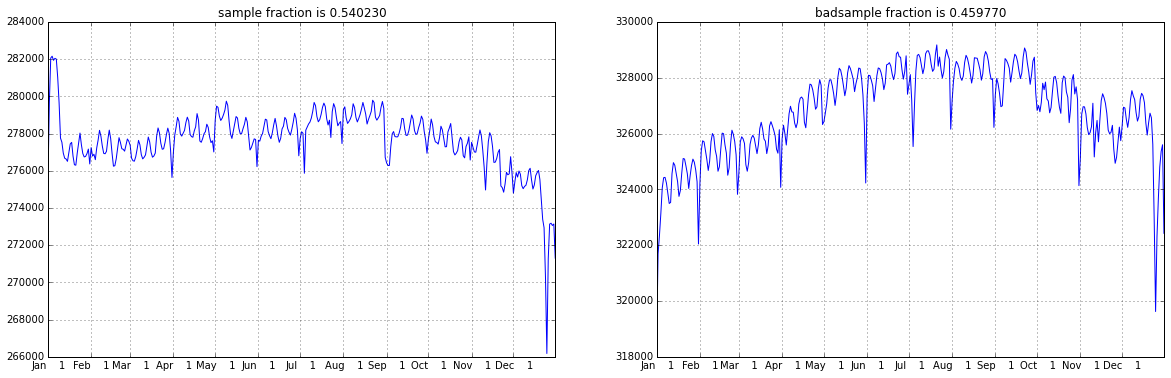

In [192]:
remove_num=80
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=year_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=year_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/year_num
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction);
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);

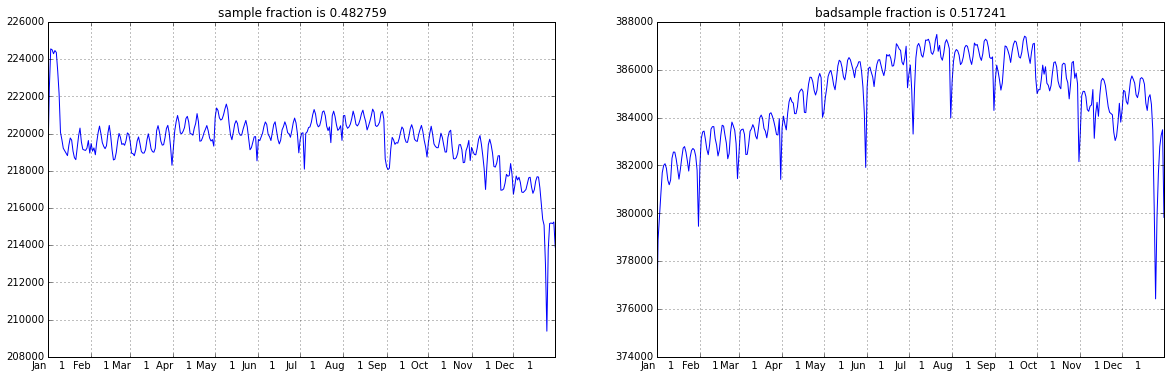

In [194]:
remove_num=90
bad_dic=np.array(overlap_rdd.take(remove_num))[:,1]
new_sample=year_rdd.filter(lambda x:x[0] not in bad_dic)
samp=new_sample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
new_badsample=year_rdd.filter(lambda x:x[0] in bad_dic)
badsamp=new_badsample.map(lambda x:x[1]).reduce(lambda x,y:x+y)
sample_fraction=new_sample.count()*1.0/year_num
badsample_fraction=1-sample_fraction
plt.figure(figsize=(20,6))
subplot(1,2,1)
YearlyPlots(samp);
title('sample fraction is %f '% sample_fraction);
subplot(1,2,2)
YearlyPlots(badsamp);
title('badsample fraction is %f '% badsample_fraction);

We can see some of the year also contribute to the dip, but not as much obvious as station. But it is interesting that when we remove about half of the data, the effect is better, we can see that from the last 2 graphs.

# Conclusion

Both subset of station and year contribute to the dip at the end of the months and christmas, but the effect of the station is more obvious, but with the fraction of removed data growing, the year's contribution can be noticed more and more obvious.
Neither of the method can remove the dip on Christmas, this makes sense.

So the dip means that at the start and end of the months, people do not want to work, but this varies from station to station and year to year. But for all condition, at Christmas, less measurements appear, this makes sense.